In [1]:
import pandas as pd
from datetime import datetime
import yfinance as yf
from scipy.stats import linregress
import numpy as np
import ta
import os
import matplotlib.pyplot as plt

In [2]:
#get circuit limit data for stocks 
circuit_limit = pd.read_csv("F:\\Bot\\MomentumStrategy\\nifty500_price_bands.csv")
circuit_limit['stock_name'] = circuit_limit['stock_name'].str.strip()
print(circuit_limit.columns)

Index(['stock_name', 'price_band'], dtype='object')


In [3]:
def exponential_regression(x, y):
    #log of closing price
    log_y = np.log(y)

    #get slope, and r_value
    slope, intercept, r_value, _, _ = linregress(x, log_y)

    '''
    r**2 -> coefficient of determinent
    ranges from 0 - 1
    ''' 
    return slope, intercept, r_value**2 

In [4]:
def annualize_return(daily_slope):
    return ((np.exp(daily_slope) ** 250) - 1) * 100

In [5]:
def calculate_adjusted_return(df, ticker):
    '''
    returns -> list [ticker, slope, annualized_return, adjusted return]
    '''

    #getting last 90 days data
    x = np.arange(90)                   #list from 0-89
    y = df['close'].iloc[-90:].values   #last 90 closing prices


    slope, intercept, r2 = exponential_regression(x, y)
    annualized_return = annualize_return(slope)
    
    adjusted_return = annualized_return * r2
    

    return [ticker, slope, annualized_return, adjusted_return]

In [6]:
def check_circuits(df, upper_circuit=20, lower_circuit=20):
    '''
    hit -> if circuit was hit in the last 90 days
    freq -> frequency of circuit hits 
    '''

    hit = False
    freq = 0
    upper_circuit = int(upper_circuit) - 0.01
    lower_circuit = int(lower_circuit) - 0.01

    # Filtering the last 90 days data
    days_90 = df.iloc[-90:, :].copy()

    # Calculate the upper and lower circuit levels
    days_90.loc[:, 'upper_circuit'] = days_90['close'].shift(1) * (1 + upper_circuit / 100)
    days_90.loc[:, 'lower_circuit'] = days_90['close'].shift(1) * (1 - lower_circuit / 100)

    # Initialize the circuit columns 
    days_90['Hit Upper Circuit'] = False
    days_90['Hit Lower Circuit'] = False

    # Explicitly cast columns to bool dtype
    days_90['Hit Upper Circuit'] = days_90['Hit Upper Circuit'].astype(bool)
    days_90['Hit Lower Circuit'] = days_90['Hit Lower Circuit'].astype(bool)

   
    days_90.loc[days_90['high'] >= days_90['upper_circuit'], 'Hit Upper Circuit'] = True    
    days_90.loc[days_90['low'] <= days_90['lower_circuit'], 'Hit Lower Circuit'] = True

    # Count the number of hits for both upper and lower circuits
    upper_circuit_hits = days_90['Hit Upper Circuit'].sum()
    lower_circuit_hits = days_90['Hit Lower Circuit'].sum()
    freq = upper_circuit_hits + lower_circuit_hits

    # Determine if there were any hits
    if freq > 0:
        hit = True

    return hit, freq


In [7]:
def check_circuits_on_full_df(df, upper_circuit=20, lower_circuit=20):
    
    '''function only for simulation

    Returns two new columns:
    - circuit_hit_90d`: True/False if a circuit was hit in the last 90 days.
    - circuit_freq_90d`: The frequency of circuit hits in the last 90 days.'''
    
    circuit_hit_90d = []
    circuit_freq_90d = []

    for i in range(len(df)):
        if i < 90:
            # If we have less than 90 rows, use what we have
            sub_df = df.iloc[:i+1]
        else:
            # Otherwise, use the last 90 rows
            sub_df = df.iloc[i-89:i+1]

        hit, freq = check_circuits(sub_df, upper_circuit, lower_circuit)
        circuit_hit_90d.append(hit)
        circuit_freq_90d.append(freq)

    df['circuit_hit_90d'] = circuit_hit_90d
    df['circuit_freq_90d'] = circuit_freq_90d

    return df

In [8]:
def calculate_atr(df, window=14):
    atr = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=window)
    # Calculate RMA manually
    rma_atr = atr.average_true_range().ewm(alpha=1/window, min_periods=window, adjust=False).mean()
    return rma_atr

In [9]:
def get_sma(df, window = 200):
    df.columns = [i.lower() for i in df.columns]
    #SMA calcluation
    df['sma_' + str(window)] = ta.trend.sma_indicator(df['close'], window=window)
    df['sma_' + str(window)+'_above'] = df['close'] > df['sma_' + str(window)] 
    return df

In [10]:
ticker = "^CRSLDX"

# Fetch the historical data
nifty500_data = yf.download(ticker, start="2022-01-01", end="2024-08-31")
print(nifty500_data.shape)
nifty500_data = get_sma(nifty500_data)
nifty500_stocks = pd.read_csv('F:\\Bot\\csv_files\\nifty500list.csv')
#filtering csv to EQ and getting only symbol column
nifty500_stocks = nifty500_stocks.loc[nifty500_stocks['Series'] == 'EQ', 'Symbol']
nifty500_data.to_csv('nifty500.csv')

nifty500_data = pd.read_csv('nifty500.csv')
nifty500_stocks= pd.read_csv('F:\\Bot\\csv_files\\nifty500list.csv')
nifty500_stocks = nifty500_stocks.loc[nifty500_stocks['Series'] == 'EQ', 'Symbol']


[*********************100%***********************]  1 of 1 completed

(653, 6)


In [11]:
nifty500_data.tail()

,Date,open,high,low,close,adj close,volume,sma_200,sma_200_above
648,2024-08-26,23514.300781,23579.750000,23466.750000,23561.750000,23561.750000,19994300,20502.214531,True
649,2024-08-27,23592.000000,23633.199219,23555.550781,23604.849609,23604.849609,22130300,20536.411533,True
650,2024-08-28,23646.800781,23679.349609,23547.250000,23615.949219,23615.949219,24488600,20570.360781,True
651,2024-08-29,23618.250000,23664.349609,23494.449219,23631.400391,23631.400391,29804300,20604.512285,True
652,2024-08-30,23728.550781,23766.400391,23673.949219,23734.550781,23734.550781,70150200,20639.520293,True


In [12]:
def get_positional_data(nifty500_stocks, 
                        specific_date = datetime.today().date() - pd.Timedelta(days = 1),  
                        num_periods = 400, path = 'F:\\Bot\\data dump\\outputs\\', 
                        account_value = 1000000,
                        risk_factor = 0.002):
    
    '''
    nifty500_stocks ->  list of stock names
    specific_date   ->  extract data till previous date
    numperiods      ->  number of datapoints (days) to be extracted from csv
    path            ->  path for csv file for stock data

    returns a filtered dataframe
    
    '''
    
    main_df = pd.DataFrame(columns=['stock_name', 'prev_close', 'slope', 'annualized_return', 'adjusted_return', 'prev_sma_100_above', 'circuit_hitted', 'circuit_freq', 'prev_atr_20'])


    for i in nifty500_stocks:
        try:
            
            data = pd.read_csv(path + i + '.csv')  # readin file
            data['Date'] = pd.to_datetime(data['Date']).dt.date  #converting to datetime columns
            
            # Filter data up to the specific date
            data = data[data['Date'] <= specific_date]
            
            # Select the last 400 data points
            data = data.iloc[-num_periods:]
            

            # If less than 400 data points, continue to next stock
            if len(data) < num_periods:
                continue

        except Exception as e:
            print(e)
            continue

        
        ''' 
        getting sma and circuit is repeated data, we already have that in csv file
        remove it later on
        
        '''
        # Getting sma
        data = get_sma(data, 100)

        # Circuit hit
        
        circuit = circuit_limit.loc[circuit_limit['stock_name'] == i, 'price_band'].values[0]
        #print(i, circuit)
        if not circuit:
            hit, freq = check_circuits(data, 
                                    upper_circuit = circuit, 
                                    lower_circuit = circuit)
        else:
            hit, freq = check_circuits(data)
        
        # Getting atr
        data['atr_20'] = calculate_atr(data, 20)
        
        
        
        # Getting slope, annualized return, adjusted_return
        l = calculate_adjusted_return(data, i)
        new_row = {
            'stock_name': l[0],
            'prev_close': data['close'].iloc[-1],
            'slope': l[1],
            'annualized_return': l[2],
            'adjusted_return': l[3],
            'prev_sma_100_above': data['sma_100_above'].iloc[-1],
            'circuit_hitted': hit,
            'circuit_freq': freq,
            'prev_atr_20': data['atr_20'].iloc[-1]
        }
        
        # Adding to dataframe
        main_df.loc[len(main_df.index)] = new_row
    

    filtered_df = main_df.sort_values(by='adjusted_return', ascending=False)
    
    account_value = 1000000
    risk_factor = 0.002

    #filtering
    filtered_df['no_of_shares'] = [account_value * risk_factor]/filtered_df['prev_atr_20']
    filtered_df['no_of_shares'] = filtered_df['no_of_shares'].astype(int)
    
    

    #checking till our cumulative cash reached close to account value
    filtered_df['invested_amount'] = filtered_df['no_of_shares'] * filtered_df['prev_close']
    filtered_df['cumulative_invested_amount'] = filtered_df['invested_amount'].cumsum()

    
    return filtered_df

In [13]:
def get_and_save_positional_data(nifty500_stocks, specific_date):
    # Define the filename based on the specific date
    filename = f"positions_{specific_date}.csv"
    filepath = os.path.join("F:\Bot\MomentumStrategy\positionalData", filename)

    # Check if the file already exists
    if os.path.exists(filepath):
        print(f"File {filename} already exists. Loading existing data.")
        position_data = pd.read_csv(filepath)
    else:
        # Generate the positional data
        position_data = get_positional_data(nifty500_stocks, specific_date)
        
        # Save to CSV
        position_data.to_csv(filepath, index=False)
        print(f"Positional data saved to {filename}.")

    return position_data

In [14]:
def preprocess(df, stock_name):
    #getting circuits
    circuit = circuit_limit.loc[circuit_limit['stock_name'] == stock_name, 'price_band'].values[0]
    if not circuit:
            df = check_circuits_on_full_df(df, 
                                    upper_circuit = circuit, 
                                    lower_circuit = circuit)
    else:
        df = check_circuits_on_full_df(df)

    #getting sma

    df = get_sma(df, 100)
    return df

In [15]:
data_dict = {}

In [16]:
initial_cash = 1000000  # Example starting cash
risk_factor = 0.002
cash_in_hand = initial_cash
portfolio = {} 

In [17]:
import pandas as pd

def simulate(start_date, end_date, nifty500_data):
    global cash_in_hand, portfolio, data_dict

    equity = []
    dates = []

    # Convert date column to datetime
    nifty500_data['Date'] = pd.to_datetime(nifty500_data['Date'])
    current_date = start_date

    # Pre-compute SMA and circuit breaker flags for all stocks
    for stock in portfolio:
        stock_df = data_dict[stock]
        

    # Create a DataFrame to track stock exits
    stock_exit_df = pd.DataFrame(columns=['stock', 'sell_price', 'shares', 'realized_gain'])

    while current_date <= end_date:
        print(current_date)
        if current_date.weekday() in [5, 6]:  # 5 is Saturday, 6 is Sunday
           
            current_date += pd.Timedelta(days=1)
            continue


        # Daily exit condition check
        stock_to_exit = []
        for stock in list(portfolio.keys()):
            stock_df = data_dict[stock]
            current_row = stock_df[stock_df['Date'] == current_date]

            if current_row.empty:
                continue  # Skip if no data for the current date

            sma_100 = current_row['sma_100_above'].values[0]
            circuit_check = current_row['circuit_hit_90d'].values[0]

            # Check exit conditions
            if not sma_100 or circuit_check:
                stock_to_exit.append(stock)

        # Exiting stocks and adding to cash in hand
        for stock in stock_to_exit:
            next_day_open = data_dict[stock].loc[data_dict[stock]['Date'] > current_date, 'open'].values[0]
            shares = portfolio[stock]['shares']
            exit_amount = next_day_open * shares
            realized_gain = exit_amount - portfolio[stock]['invested_amount']
            cash_in_hand += exit_amount

            # Record the exit transaction
            stock_exit_df = pd.concat([stock_exit_df, pd.DataFrame({
                        'stock': [stock],
                        'sell_price': [next_day_open],
                        'shares': [shares],
                        'realized_gain': [realized_gain]
                    })], ignore_index=True)

            del portfolio[stock]

        # Weekly rebalancing and buying
        if current_date.weekday() == start_date.weekday():
            positional_data = get_and_save_positional_data(nifty500_stocks, current_date)

            # Rank-based exits
            positional_data['rank'] = positional_data['stock_name'].rank(method='first')

            ranks = positional_data.set_index('stock_name')['rank']
            for stock in list(portfolio.keys()):
                if stock in ranks and ranks[stock] > 75:
                    next_day_open = data_dict[stock].loc[data_dict[stock]['Date'] > current_date, 'open'].values[0]
                    shares = portfolio[stock]['shares']
                    exit_amount = next_day_open * shares
                    realized_gain = exit_amount - portfolio[stock]['invested_amount']
                    cash_in_hand += exit_amount

                    # Record the exit transaction
                    stock_exit_df = pd.concat([stock_exit_df, pd.DataFrame({
                                'stock': [stock],
                                'sell_price': [next_day_open],
                                'shares': [shares],
                                'realized_gain': [realized_gain]
                            })], ignore_index=True)

                    del portfolio[stock]

            # Rebalancing: Reduce shares
            for _, row in positional_data.iterrows():
                if row['stock_name'] in portfolio:
                    current_shares = portfolio[row['stock_name']]['shares']
                    new_shares = row['no_of_shares']

                    if abs(new_shares - current_shares) / current_shares > 0.05 and current_shares > new_shares:
                        shares_to_sell = current_shares - new_shares
                        sell_price = data_dict[row['stock_name']].loc[data_dict[row['stock_name']]['Date'] >= current_date, 'open'].values[0]
                        sell_amount = shares_to_sell * sell_price

                        portfolio[row['stock_name']]['shares'] = new_shares
                        portfolio[row['stock_name']]['invested_amount'] -= sell_amount
                        cash_in_hand += sell_amount

            # Rebalancing: Add shares
            for _, row in positional_data.iterrows():
                if row['stock_name'] in portfolio:
                    current_shares = portfolio[row['stock_name']]['shares']
                    new_shares = row['no_of_shares']

                    if new_shares > current_shares and abs(new_shares - current_shares) / current_shares > 0.05:
                        shares_to_buy = new_shares - current_shares
                        buy_price = data_dict[row['stock_name']].loc[data_dict[row['stock_name']]['Date'] >= current_date, 'open'].values[0]
                        buy_amount = shares_to_buy * buy_price

                        if cash_in_hand >= buy_amount:
                            portfolio[row['stock_name']]['shares'] += shares_to_buy
                            portfolio[row['stock_name']]['invested_amount'] += buy_amount
                            cash_in_hand -= buy_amount

            # Buying new stocks
            for _, row in positional_data.iterrows():
                if row['stock_name'] not in portfolio:
                    if (
                        row['prev_sma_100_above'] 
                        and not row['circuit_hitted'] 
                        and row['no_of_shares'] != 0
                        and cash_in_hand > row['invested_amount'] #main criteria
                        and nifty500_data.loc[nifty500_data['Date'].dt.date <= current_date, 'sma_200_above'].values[-1]
                        
                    ):
                        
                        stock_df = data_dict.get(row['stock_name'], pd.read_csv("F:\\Bot\\data dump\\outputs\\" + row['stock_name'] + '.csv'))
                        stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date
                        data_dict[row['stock_name']] = stock_df

                        #we buy the stock on current opening
                        #assuming that we run this before market hours in morning

                        current_opening_price = stock_df.loc[stock_df['Date'] >= current_date, 'open'].values[0]
                        portfolio[row['stock_name']] = {
                            'entry_date': current_date,
                            'shares': row['no_of_shares'],
                            'invested_amount': row['no_of_shares'] * current_opening_price
                        }

                        cash_in_hand -= portfolio[row['stock_name']]['invested_amount']

        # Calculate equity
        equity_value = sum(
            
            portfolio[stock]['shares'] * data_dict[stock].loc[data_dict[stock]['Date'] >= current_date, 'close'].values[0]
            
            for stock in portfolio
        ) + cash_in_hand

        equity.append(equity_value)
        dates.append(current_date)

        current_date += pd.Timedelta(days=1)

    return equity, dates

In [18]:
start_date = datetime(2024, 1, 1).date()
#the start_date will be considered for rebalacing and new buying.
end_date = datetime(2024, 8, 30).date()

equity, dates = simulate(start_date, end_date, nifty500_data)

2024-01-01
File positions_2024-01-01.csv already exists. Loading existing data.
2024-01-02
2024-01-03
2024-01-04
2024-01-05
2024-01-06
2024-01-07
2024-01-08
File positions_2024-01-08.csv already exists. Loading existing data.
2024-01-09
2024-01-10
2024-01-11
2024-01-12
2024-01-13
2024-01-14
2024-01-15
File positions_2024-01-15.csv already exists. Loading existing data.
2024-01-16
2024-01-17
2024-01-18
2024-01-19
2024-01-20
2024-01-21
2024-01-22
File positions_2024-01-22.csv already exists. Loading existing data.
2024-01-23
2024-01-24
2024-01-25
2024-01-26
2024-01-27
2024-01-28
2024-01-29
File positions_2024-01-29.csv already exists. Loading existing data.
2024-01-30
2024-01-31
2024-02-01
2024-02-02
2024-02-03
2024-02-04
2024-02-05
File positions_2024-02-05.csv already exists. Loading existing data.
2024-02-06
2024-02-07
2024-02-08
2024-02-09
2024-02-10
2024-02-11
2024-02-12
File positions_2024-02-12.csv already exists. Loading existing data.
2024-02-13
2024-02-14
2024-02-15
2024-02-16


Visualizations

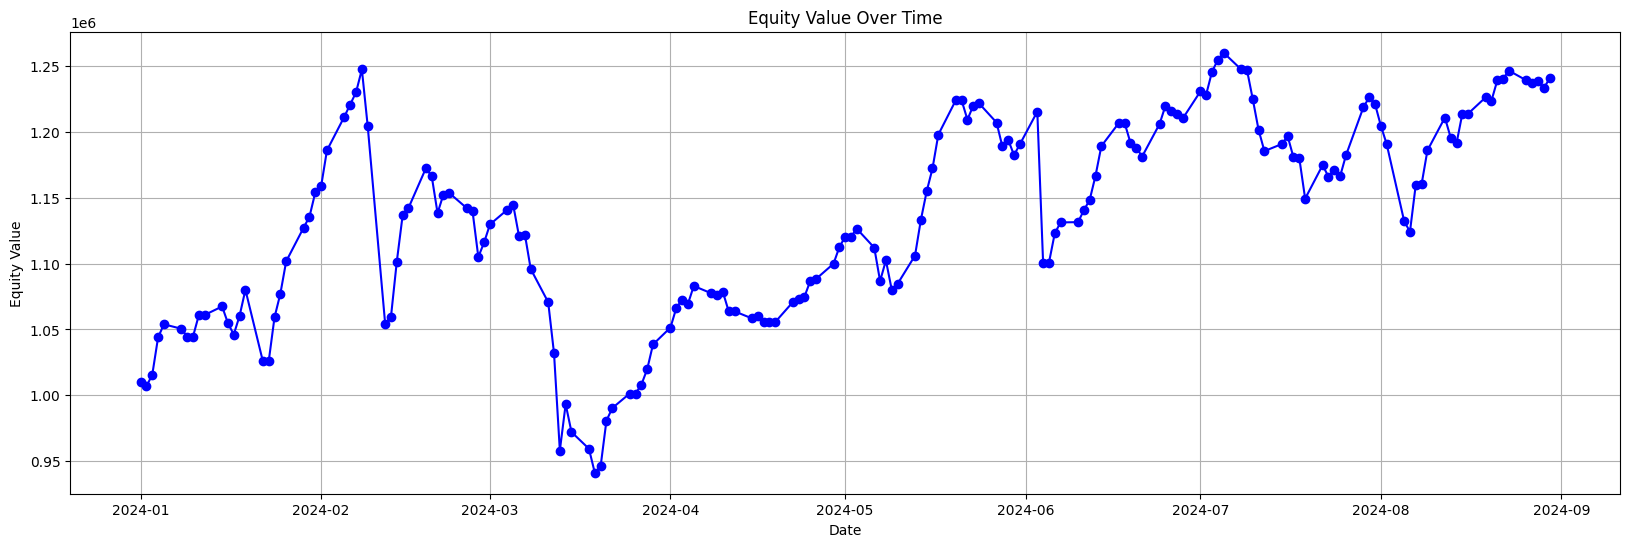

In [19]:
plt.figure(figsize=(20, 6))
plt.plot(dates,equity, marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.title('Equity Value Over Time')
plt.grid(True)
plt.show()

In [20]:
def calculate_cagr(beginning_value, ending_value, years):
    
    if beginning_value <= 0 or years <= 0:
        raise ValueError("Beginning value and years must be greater than zero.")
    
    cagr = (ending_value / beginning_value) ** (1 / years) - 1
    
    return cagr * 100  


years = 1 + (8 / 12)     

cagr = calculate_cagr(equity[0], equity[-1], years)
print(f"The CAGR is: {cagr:.2f}%")

The CAGR is: 13.13%


In [21]:
print(len(equity))

175


In [22]:
for i, j in zip(dates, equity):
    print(i, j)

2024-01-01 1010041.8300000001
2024-01-02 1006840.4099999999
2024-01-03 1015548.0100000001
2024-01-04 1043881.0700000001
2024-01-05 1053870.33
2024-01-08 1050485.81
2024-01-09 1044588.7000000002
2024-01-10 1044543.8500000001
2024-01-11 1060839.81
2024-01-12 1060959.96
2024-01-15 1067412.6400000001
2024-01-16 1054691.83
2024-01-17 1046096.21
2024-01-18 1060324.83
2024-01-19 1080055.6100000003
2024-01-22 1025787.17
2024-01-23 1025787.17
2024-01-24 1059207.66
2024-01-25 1077049.06
2024-01-26 1101647.61
2024-01-29 1127229.6099999996
2024-01-30 1135468.12
2024-01-31 1153951.1199999999
2024-02-01 1158564.7099999997
2024-02-02 1185807.5399999998
2024-02-05 1211496.0599999998
2024-02-06 1220622.5399999998
2024-02-07 1229932.63
2024-02-08 1247271.6199999999
2024-02-09 1204366.0
2024-02-12 1054232.75
2024-02-13 1059720.9500000002
2024-02-14 1101480.5900000003
2024-02-15 1136472.9900000005
2024-02-16 1142084.1300000004
2024-02-19 1172325.9100000006
2024-02-20 1166122.04
2024-02-21 1138223.46000000